## APP
Author: Hao Sun and Jenny Empawi

In [2]:
library(data.table)
library(dplyr)
library(magrittr)
library(ggplot2)
library(ggrepel)
library(cowplot)
library(tidyverse)
library(stringr) 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.2.0     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ tidyr::extract()     masks magrittr::extract()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    

## Data loading

In [3]:
effect_table_snatac =  read_delim("/data/analysis_result/snatac_fsusie/top_loci/ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz") # path in cloud
#effect_table_snatac <-  read_delim("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_ZYX/ROSMAP_Kelis_snatac_fsusie.exported.toploci.bed.gz") # path in BU cluster

Rows: 554 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): #chr, a1, a2, variant_ID, event_ID, region_ID, cs_id, cs_root, epi...
dbl  (8): start, end, TADB_start, TADB_end, maf, PIP, cs_coverage_0.95, grid...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
effect_table_snatac_app <- effect_table_snatac %>% filter(region_ID == "chr21_21882581_26518865")

In [5]:
effect_table_snatac_app$cs_id

[1] "ROSMAP_snATAC_Kelis_Ast:chr21_21882581_26518865:2"

In [6]:
#source("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_ZYX/get_gene_annotations.R")  # path in BU cluster
#source("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_ZYX/interpolate_effect_estimates.R") # path in BU cluster

source("/data/interactive_analysis/hs3163/snatac_case_study/fsusie-experiments/scripts_plot/cases_study/get_gene_annotations.R")  # path in cloud
source("/data/interactive_analysis/hs3163/snatac_case_study/fsusie-experiments/scripts_plot/cases_study/interpolate_effect_estimates.R") # path in cloud

#gene_file <- file.path("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_ZYX/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf")  # path in BU cluster
gene_file <- file.path("/data/resource/references/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.ERCC.gtf")  # path in cloud

genes <- get_gene_annotations(gene_file)

#eQTL_1 <- readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/ROSMAP_DeJager_eQTL.ENSG00000142192.univariate_susie_twas_weights.rds") #FIXME # These two rds is required to load the marginal sumstat for the null snps
eQTL_1 <- readRDS("/data/analysis_result/finemapping_twas/susie_twas/ROSMAP_DeJager_eQTL.ENSG00000142192.univariate_susie_twas_weights.rds") # path in cloud

#GWAS_1 <- readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/RSS_QC_RAISS_imputed.chr21_24215031_26405838.univariate_susie_rss.rds") #FIXME # These two rds is required to load the marginal sumstat for the null snps
GWAS_1 <- readRDS("/data/interactive_analysis/hs3163/snatac_case_study/RSS_QC_RAISS_imputed.chr21_24215031_26405838.univariate_susie_rss.rds") # path in cloud

key_marker <- 26171790
pos0 <- 25500000
pos1  <- 26405838

In [7]:
#diff_cor <- readRDS("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/APP_snatac_case_study.homo_alt_vs_homo_ref.diff_in_cor.rds") # path in BU cluster
diff_cor <- readRDS("/data/interactive_analysis/hs3163/snatac_case_study/APP_snatac_case_study.homo_alt_vs_homo_ref.diff_in_cor.rds") # path in cloud



In [8]:
#p6dat <- read_delim("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/Astro.chr21_21882581_26518865.fsusie_mixture_normal_none__top_pc_weights.raw_input.tsv") # path in BU cluster
p6dat <- read_delim("/data/interactive_analysis/hs3163/snatac_case_study/Astro.chr21_21882581_26518865.fsusie_mixture_normal_none__top_pc_weights.raw_input.tsv") # path in cloud

# compute diff_mat as you have
diff_mat <- p6dat %>% filter(genotype == 2) %>% 
  select(`25386103`:`26469950`) %>% 
  cor(use = "pairwise.complete.obs") -
  p6dat %>% filter(genotype == 0) %>% 
  select(`25386103`:`26469950`) %>% 
  cor(use = "pairwise.complete.obs")

# get matrix indices where diff > 0.8
idx <- which(diff_mat > -3, arr.ind = TRUE)

# assemble a data.frame of row/col names + value
diff_cor <- data.frame(
  row = rownames(diff_mat)[idx[,1]],
  col = colnames(diff_mat)[idx[,2]],
  diff = diff_mat[idx]
)

Rows: 68 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): sample
dbl (45): 21969345, 22254003, 22343124, 24045583, 24046115, 24436483, 249394...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
(eQTL_1$ENSG00000142192$Ast_DeJager_eQTL$top_loci) %>% filter(str_detect(variant_id,"26171790"))

variant_id,betahat,sebetahat,maf,pip,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr21:26171790:A:G,0.191449,0.03906881,0.4379475,0.01346267,1,0,0


## Annotate the peaks

In [10]:
#snatac_cood <- read_delim("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/snatac_coord.tsv") # path in BU cluster
snatac_cood <- read_delim("/data/interactive_analysis/hs3163/output_file/snatac_coord.tsv") # path in cloud

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 756888 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #chr, ID
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
#remap_ast <- read_delim("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/remap2022_astrocyte_nr_macs2_hg38_v1_0.bed.gz", col_names = F) # path in BU cluster
remap_ast <- read_delim("/data/interactive_analysis/hs3163/external_data/remap2022_astrocyte_nr_macs2_hg38_v1_0.bed.gz", col_names = F) # path in cloud


Rows: 76945 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): X1, X4, X6
dbl (5): X2, X3, X5, X7, X8
num (1): X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
remap_ast <- remap_ast %>% filter(X1 == "chr21"  )

In [13]:
remap_ast %>% 
    filter(X2 > pos0 , X3 < pos1 ) %>%
    separate_rows(X4,sep = ":") %>%
    filter(!str_detect(X4,","))%>%
    head

X1,X2,X3,X4,X5,X6,X7,X8,X9
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
chr21,25507594,25507840,CTCF,146,.,25507721,25507722,25214056
chr21,25562036,25562434,CTCF,297,.,25562218,25562219,25214056
chr21,25606771,25606934,CTCF,1,.,25606832,25606833,25214056
chr21,25606771,25606934,astrocyte,1,.,25606832,25606833,25214056
chr21,25607426,25607791,CTCF,526,.,25607603,25607604,25214056
chr21,25608203,25608646,CTCF,588,.,25608443,25608444,25214056


## Data preparation

#### Section 1: GWAS

In [14]:
GWAS_1 <- (GWAS_1[[1]][[2]]) %>% 
            select(variant_id,pos,beta,se,z,pval = pvalue )%>%
            mutate(CS = variant_id %in% ((GWAS_1[[1]][[1]][["top_loci"]]) %>%
            filter(cs_coverage_0.95 != 0) %>%
            pull(variant_id)))%>%
            mutate(variant_id = paste0("chr",variant_id ))%>%
            mutate( id = ifelse(CS != 0, variant_id,NA))

#### Section 2: eQTL

In [15]:
eQTL_pdat_1 <- tibble(variant_id = eQTL_1[[1]][["Ast_DeJager_eQTL"]][["variant_names"]], beta = eQTL_1[[1]][["Ast_DeJager_eQTL"]][["sumstats"]][[1]], se = eQTL_1[[1]][["Ast_DeJager_eQTL"]][["sumstats"]][[2]]) %>% 
                      mutate(z = beta/se, CS = variant_id %in% ((eQTL_1[[1]][["Ast_DeJager_eQTL"]][["top_loci"]]) %>%
                      filter(cs_coverage_0.95 == 1 )%>%
                      pull(variant_id))) %>%
                      separate(variant_id,into = c("chr","pos"),remove = F)%>%mutate(pos = as.numeric(pos), id = ifelse(CS != 0, variant_id,NA) ) %>%
                      mutate(pval = 2 * pnorm(-abs(z)))

Warning message:
“Expected 2 pieces. Additional pieces discarded in 11374 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


#### Section 4: Panel 3 – mSNP PIP fine-mapping

In [16]:
pdat3 <- data.frame(
  id  = effect_table_snatac_app$variant_ID,
  pos = effect_table_snatac_app$end,
  pip = effect_table_snatac_app$PIP,
  cs  = effect_table_snatac_app$cs_coverage_0.95,
  stringsAsFactors=FALSE
)
rownames(pdat3) <- pdat3$id

pdat4 <- effect_table_snatac_app %>%
            select(pos	= epi_mark_positions,effect = epi_mark_effects) %>%
            separate_rows(pos,effect,sep = ";")%>%mutate_all(as.numeric)

pdat5 <- genes %>%
  filter(chromosome=="chr21", end>pos0, start<pos1) %>%
  mutate(
    start = start,
    end   = end,
    tss   = ifelse(strand=="+", start, end),
    y     = seq(0,1,length.out=n())
  )

### Setup the data for the loop plot

In [17]:
# convert to data.tables
setDT(remap_ast); setDT(pdat4)

# if your effect table lacks a chr column, add it (here all on chr21)
pdat4[, X1 := remap_ast$X1[1]]

# define the same interval columns in both tables
remap_ast[,   `:=`(start = X2, end = X3)]
pdat4[, `:=`(start = pos, end = pos)]

# key both tables on chr, start, end
setkey(remap_ast, X1, start, end)
setkey(pdat4, X1, start, end)

# find points (pos) within ranges [X2,X3]
res <- foverlaps(pdat4, remap_ast, type = "within", nomatch = 0L)


In [18]:
cre <- res %>% separate(X4, into = c("target","biotype"), sep = "\\:") 

In [19]:
# define a y‐position for the arcs just below the SNATAC effects
y_arc <- 0.1

# set a diff threshold to filter which arcs to draw
diff_thresh <- 0.8

# prepare the arc data.frame, filtering by diff and flipping curvature

df3 <- diff_cor %>%
  filter(abs(diff) > diff_thresh) %>%
  mutate(
    x    = as.numeric(row),
    xend = as.numeric(col)) %>%
  # Calculate coord_diff first
  mutate(coord_diff = abs(xend - x)) %>%
  left_join(pdat4 %>% select(pos, effect), by = c("x" = "pos")) %>%
  rename(y = effect) %>%
  left_join(pdat4 %>% select(pos, effect), by = c("xend" = "pos")) %>%
  rename(yend = effect) %>%
  mutate(curvature = (coord_diff / max(coord_diff, na.rm = TRUE)) * 0.8) %>%
  filter(x < xend) #%>%filter(row %in% cre$pos  |  col %in% cre$pos )

df4 <- df3 %>% filter(row %in% cre$pos  | col %in% cre$pos )

## Plotting 

Warning message:
“Removed 6153 rows containing missing values or values outside the scale range
(`geom_point()`).”


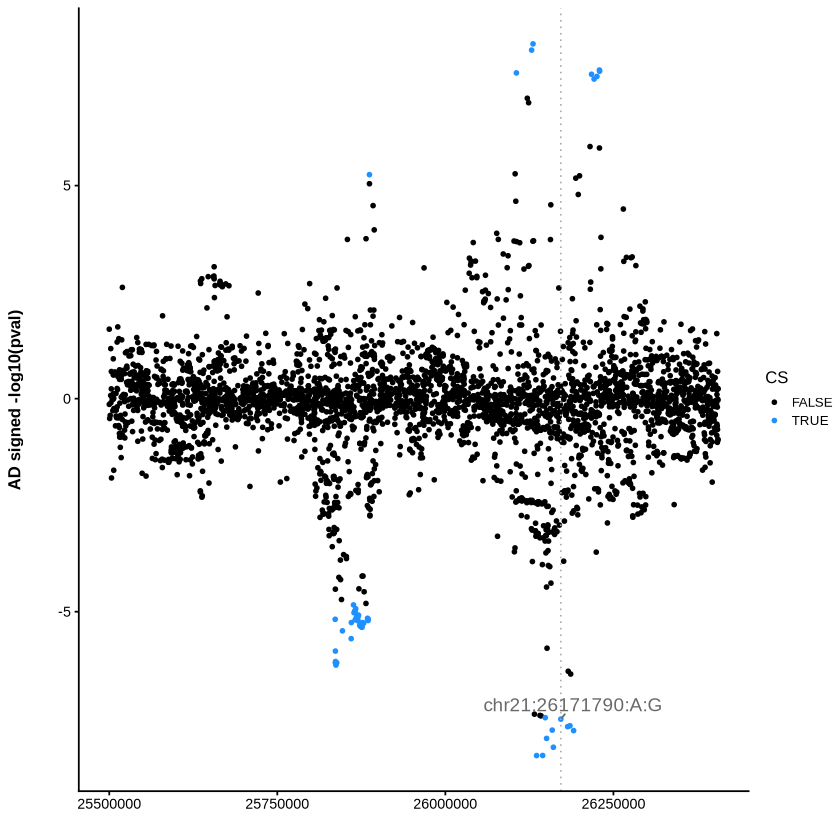

In [20]:
p1 <- ggplot(GWAS_1, aes(x = pos, y = -log10(as.numeric(pval))*sign(z), col=CS,label = id)) +
  geom_point(size=1) +  geom_point(size=1, data = GWAS_1%>%filter(str_detect(variant_id,"25828851" )),color = "red") +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  geom_text_repel(size=4, color="dimgray", segment.color="dimgray",data = GWAS_1%>%filter(id == "chr21:26171790:A:G"), min.segment.length=0, max.overlaps=Inf) +
  scale_color_manual(values=c("black","dodgerblue")) +
  scale_x_continuous(limits=c(pos0,pos1)) +
  labs(x="", y="AD signed -log10(pval)") + theme_cowplot(font_size=10) +
  theme(axis.title.y = element_text(size=10, margin=margin(r=20), face="bold"),
        legend.title =element_text(size=10),
        legend.text = element_text(size=8))
  

p1

Warning message:
“Removed 7068 rows containing missing values or values outside the scale range
(`geom_point()`).”


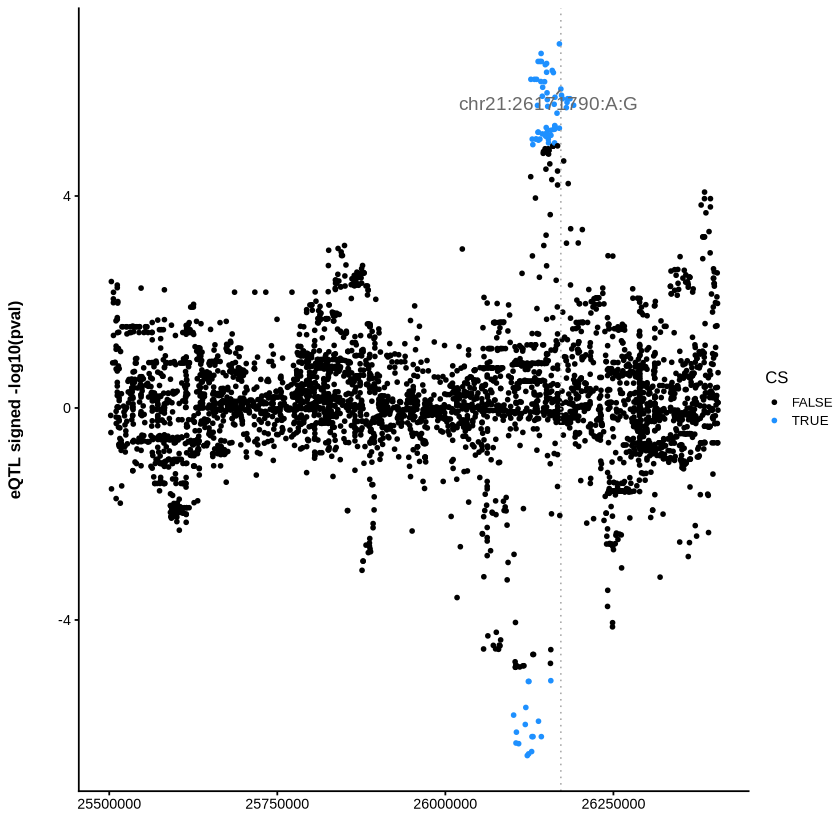

In [21]:
p2 <- ggplot(eQTL_pdat_1, aes(x = pos, y = -log10(as.numeric(pval))*sign(z), col=CS,label = id)) +
  geom_point(size=1) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  geom_text_repel(size=4, color="dimgray", segment.color="dimgray",data = eQTL_pdat_1%>%filter(id == "chr21:26171790:A:G"), min.segment.length=0, max.overlaps=Inf) +
  scale_color_manual(values=c("black","dodgerblue")) +
  scale_x_continuous(limits=c(pos0,pos1)) +
  labs(x="", y="eQTL signed -log10(pval)") + theme_cowplot(font_size=10) +
  theme(axis.title.y = element_text(size=10,margin=margin(r=20), face="bold"),
       legend.text = element_text(size=8),
       legend.title = element_text(size=10))

p2

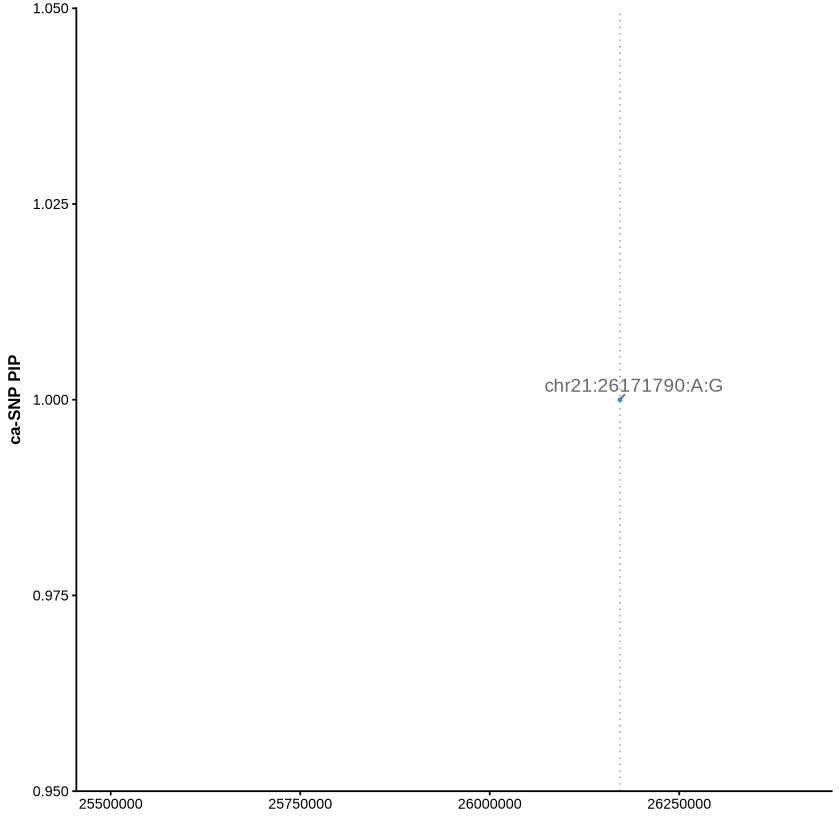

In [22]:
p3 <- ggplot(pdat3, aes(pos, pip,label=id)) +
  geom_point(size=0.75,color = "dodgerblue") +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  geom_text_repel(size=4, color="dimgray", segment.color="dimgray", min.segment.length=0, max.overlaps=Inf) +
  scale_x_continuous(limits=c(pos0,pos1)) +
  labs(x="", y="ca-SNP PIP") +
  theme_cowplot(font_size=10) +
  theme(axis.title.y = element_text(size = 10, face="bold"))

p3

#### Section 5: Panel 4 - SNATAC effect estimates

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_curve()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_curve()`).”


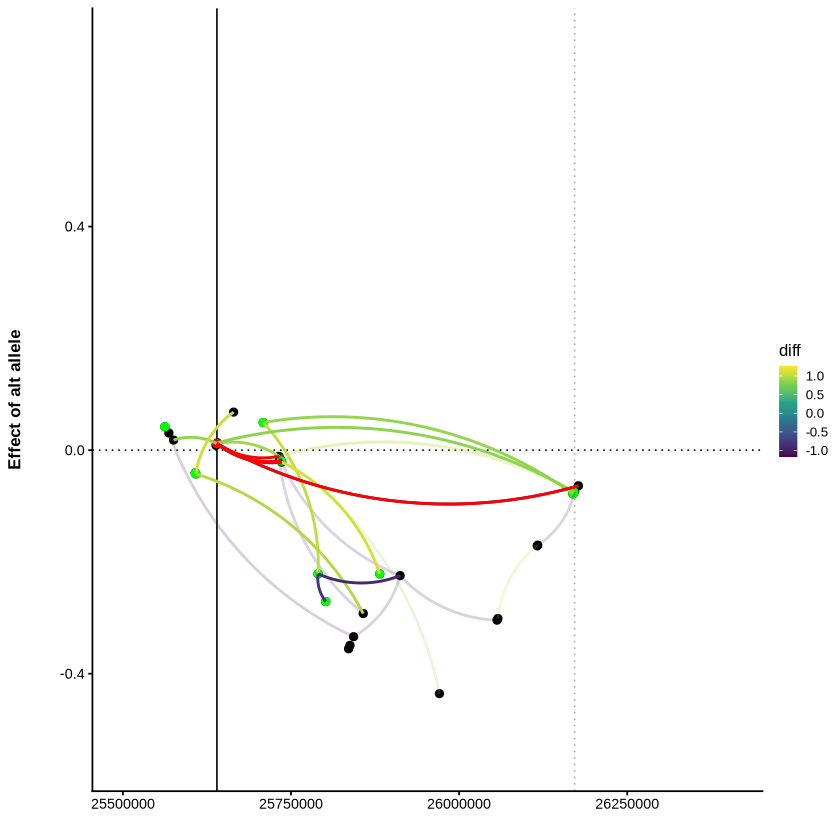

In [23]:
curv = 0.2

p4 <- ggplot() +
  # SNATAC effect estimates (panel 4)
  geom_hline(yintercept = 0, linetype = "dotted") +
  geom_point(data = subset(pdat4), aes(x = pos, y = effect), size = 2) +
  geom_vline(xintercept = 25639873) +
  geom_vline(xintercept = key_marker, linetype = "dotted", color = "darkgray") +
  geom_point(data = cre %>% filter(str_detect(target, "CTCF")), aes(x = pos, y = effect), color = "green", size = 2) +
  geom_point(data = cre %>% filter(str_detect(target, "EZH2")), aes(x = pos, y = effect), color = "red", size = 2) +
  
  # co-accessibility arcs on top: Clean and filter data inline for each geom_curve
  geom_curve(
    data = {df3 %>% filter(diff > 0) %>% filter(!is.na(x), !is.na(y), !is.na(xend), !is.na(yend)) %>% filter(!(x == xend & y == yend))},
    aes(x = x, y = y, xend = xend, yend = yend, color = diff),
    curvature = -curv, ncp = 100, alpha = 0.2, size = 0.8) +
  geom_curve(
    data = {df3 %>% filter(diff < 0) %>% filter(!is.na(x), !is.na(y), !is.na(xend), !is.na(yend)) %>% filter(!(x == xend & y == yend))},
    aes(x = x, y = y, xend = xend, yend = yend, color = diff),
    curvature = curv, ncp = 100, alpha = 0.2, size = 0.8) +
  geom_curve(
    data = {df4 %>% filter(diff > 0) %>% filter(!is.na(x), !is.na(y), !is.na(xend), !is.na(yend)) %>% filter(!(x == xend & y == yend))},
    aes(x = x, y = y, xend = xend, yend = yend, color = diff),
    curvature = -curv, ncp = 100, size = 0.8) +
  geom_curve(
    data = {df4 %>% filter(diff < 0) %>% filter(!is.na(x), !is.na(y), !is.na(xend), !is.na(yend)) %>% filter(!(x == xend & y == yend))},
    aes(x = x, y = y, xend = xend, yend = yend, color = diff),
    curvature = curv, ncp = 100, size = 0.8) +
  geom_curve(data = {df4 %>% filter(row == 25639873) %>% filter(!is.na(x), !is.na(y), !is.na(xend), !is.na(yend)) %>% filter(!(x == xend & y == yend))},
    aes(x = x, y = y, xend = xend, yend = yend, color = diff),
    curvature = curv, ncp = 100, size = 0.8, color = "red") +
  # scales and theme
  labs(x = "", y = "Effect of alt allele") +
  scale_x_continuous(limits = c(pos0, pos1)) +
  scale_color_viridis_c(option = "D") +
  theme_cowplot(font_size = 10) + 
  theme(axis.title.y = element_text(size = 10, margin = margin(r=20), face = "bold"),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 10))

p4

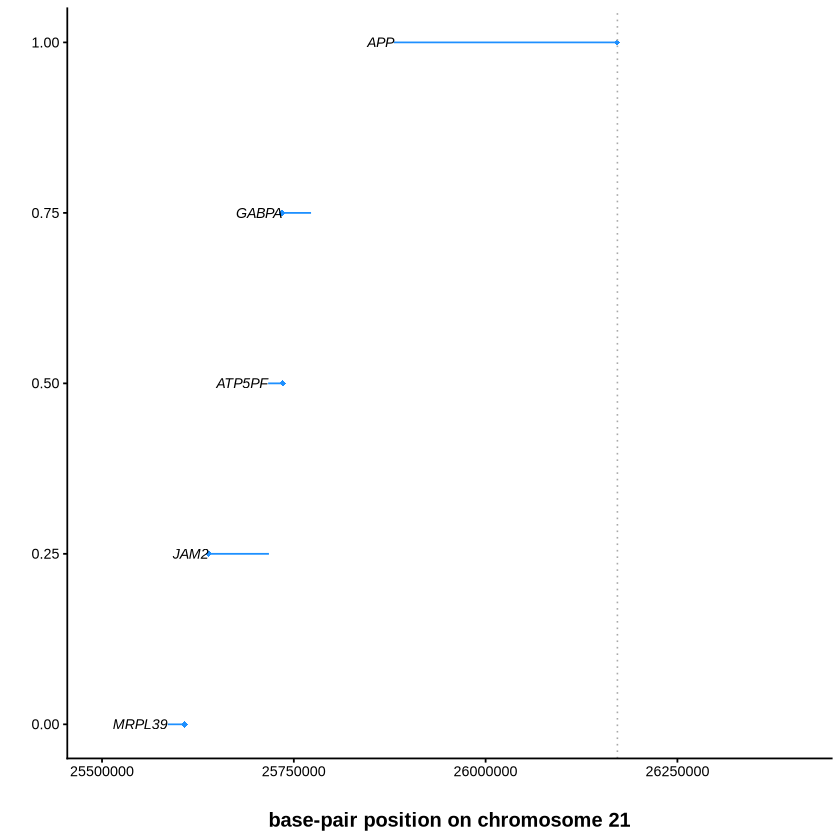

In [24]:
p5 <- ggplot(pdat5, aes(x=start, xend=end, y=y, yend=y, label=gene_name)) +
  geom_segment(color="dodgerblue", size=0.5) +
  geom_point(aes(x=tss), color="dodgerblue", shape=18, size=1.5) +
  geom_text(color="black", size = 3, fontface="italic", hjust="right", nudge_x=-0.003) +
  geom_vline(xintercept=key_marker, linetype="dotted", color="darkgray") +
  #scale_x_continuous(limits=c(pos0,pos1)/1e6, breaks=seq(45,48,0.05)) +
  scale_x_continuous(limits=c(pos0,pos1))+  labs(x="base-pair position on chromosome 21", y="") +
  theme_cowplot(font_size=10) +
  theme(
      axis.title.x = element_text(size = 12, margin = margin(t=20), face = "bold"))
  

p5

Warning message:
“Removed 6153 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 7068 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_curve()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_curve()`).”


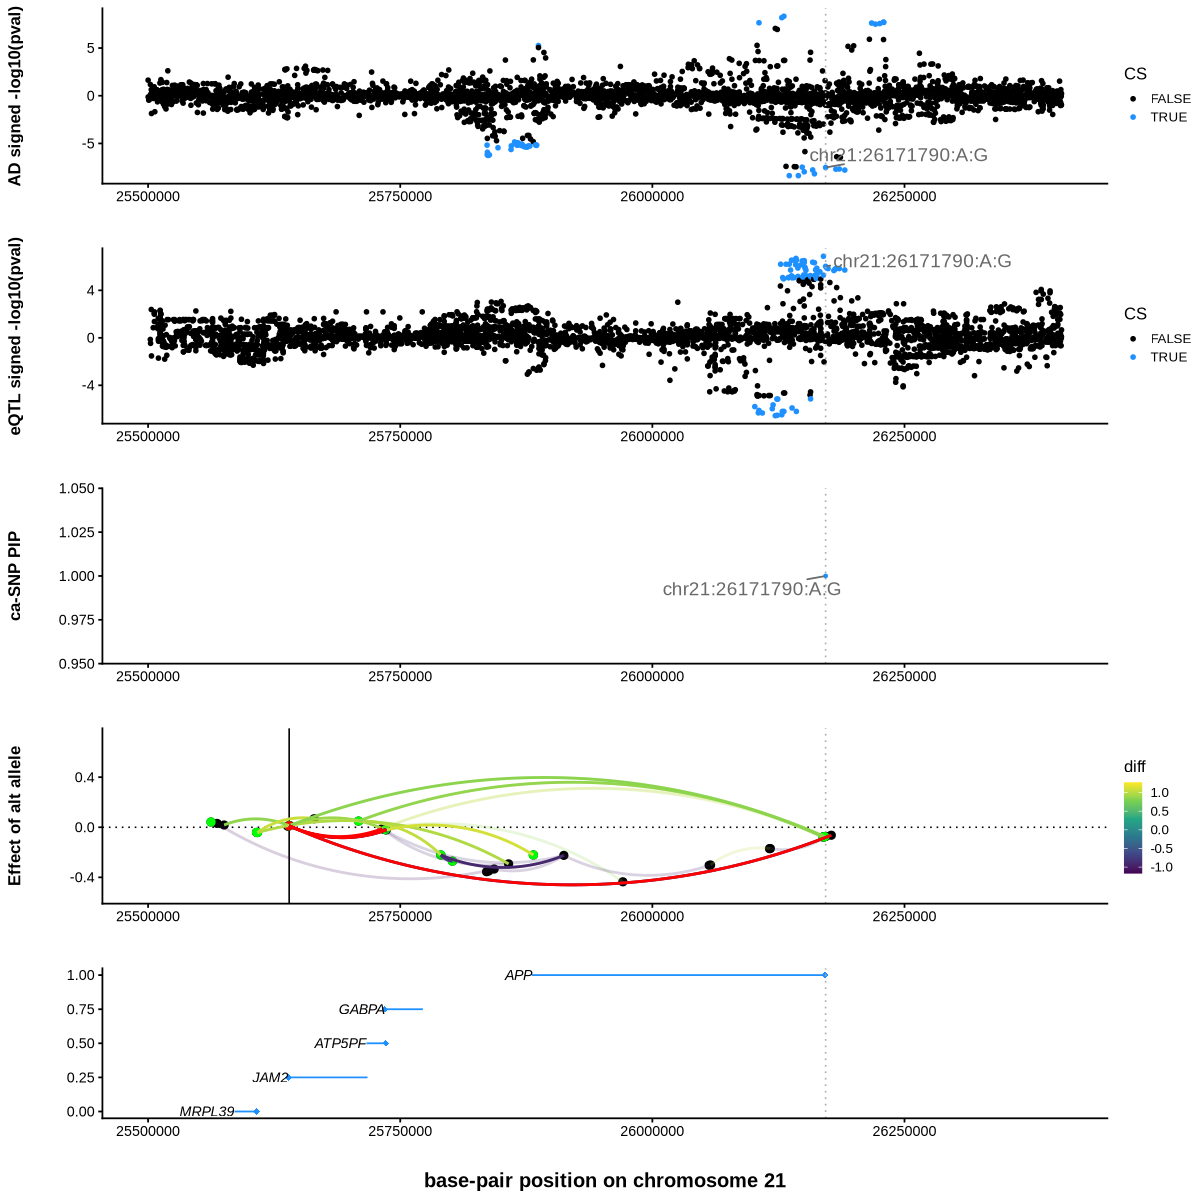

In [25]:
fig <- plot_grid(p1+theme(text = element_text(size =14)), 
                 p2+theme(text = element_text(size =14)), 
                 p3+theme(text = element_text(size =14)), 
                 p4+theme(text = element_text(size =14)),
                 p5+theme(text = element_text(size =14 )), nrow=5, align="v")

options(repr.plot.width = 10, repr.plot.height = 10)
fig
ggsave("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_APP/Figure_APP.png", fig, width = 8, height = 12, dpi = 300)